In [1]:
# Read & update data from MongoDB
from pymongo import MongoClient
import numpy as np
from setting import DB_HOST, DB_PORT, DB_NAME

def get_fps(collection_name, find_opt = {'_id': 0, 'fingerprint': 1, 'coordinate': 1}):
    collection = MongoClient(DB_HOST, DB_PORT)[DB_NAME][collection_name]
    docs = list(collection.find({}, find_opt))

    docs.sort(key=lambda x: x['coordinate'])
    
    fps = np.array([doc['fingerprint'] for doc in docs])
    cordnts = np.array([doc['coordinate'] for doc in docs])
    
    return fps, cordnts

def update(where, update_query):
    #     where = {'coordinate': [100, 100]}
    #     update_query = {'$set': {'coordinate': [6, 30]}}

    collection = MongoClient(DB_HOST, DB_PORT)[DB_NAME]['testpoint_N1_7F_half(ss4)']
    collection.update_many(where, update_query)

In [33]:
# options
CONSTRUCTION_TYPE = 'WS'
NUM_SS = 10
CONSTRUCTION_OPT = CONSTRUCTION_TYPE + '_SS(%d)' % NUM_SS
CONSTRUCTION_OPT

'WS_SS(10)'

In [67]:
# Train KNN
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt

n_neighbors, num_fp = 3, 100
selected_ss = [2, 4, 6, 8]
# selected_ss = range(10)
selected_ss = [ss - 1 for ss in selected_ss]
rm_name, testpoints_name = 'radiomap_N1_7F_half(ss10)', 'testpoint_N1_7F_half(ss10)'

train_fps, train_cordnts = get_fps(rm_name)
test_fps, test_cordnts = get_fps(testpoints_name)

# select certain sniffer station for fp
train_fps, test_fps, = train_fps[:, selected_ss], test_fps[:, selected_ss]

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
pca_train_fps = pca.fit_transform(train_fps)
pca_test_fps = pca.transform(test_fps)

In [68]:
neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(train_fps, np.arange(train_fps.shape[0]))

KNeighborsClassifier(n_neighbors=3)

In [69]:
# Predict test data
_, neigh_inds = neigh.kneighbors(test_fps)

err_lst = []

for cordnt, neigh_idx in zip(test_cordnts, neigh_inds):
    neigh_cordnt = train_cordnts[neigh_idx]    
    pred_cordnt = np.array([neigh_cordnt[:, 0].mean(), neigh_cordnt[:, 1].mean()])
    
    error = np.linalg.norm(pred_cordnt - cordnt)
    err_lst.append(error)
    
    print('neigh cordnt:', neigh_cordnt.tolist())
    print('pred_cordnt: {}\treal_cordnt: {}'.format(pred_cordnt, cordnt))
    print('error distance(m):', error)
    print()

err_lst = np.array(err_lst)

neigh cordnt: [[2.84, 14.0], [9.19, 14.0], [6.65, 14.0]]
pred_cordnt: [ 6.22666667 14.        ]	real_cordnt: [ 4 14]
error distance(m): 2.2266666666666666

neigh cordnt: [[6.65, 14.0], [9.19, 14.0], [2.84, 14.0]]
pred_cordnt: [ 6.22666667 14.        ]	real_cordnt: [ 4 14]
error distance(m): 2.2266666666666666

neigh cordnt: [[2.84, 14.0], [6.65, 14.0], [9.19, 14.0]]
pred_cordnt: [ 6.22666667 14.        ]	real_cordnt: [ 4 14]
error distance(m): 2.2266666666666666

neigh cordnt: [[2.84, 14.0], [6.65, 14.0], [9.19, 14.0]]
pred_cordnt: [ 6.22666667 14.        ]	real_cordnt: [ 4 14]
error distance(m): 2.2266666666666666

neigh cordnt: [[2.84, 14.0], [6.65, 14.0], [9.19, 14.0]]
pred_cordnt: [ 6.22666667 14.        ]	real_cordnt: [ 4 14]
error distance(m): 2.2266666666666666

neigh cordnt: [[2.84, 14.0], [6.65, 14.0], [9.19, 14.0]]
pred_cordnt: [ 6.22666667 14.        ]	real_cordnt: [ 4 14]
error distance(m): 2.2266666666666666

neigh cordnt: [[6.65, 14.0], [9.19, 14.0], [2.84, 14.0]]
pred_co

In [70]:
# Accuracy(distance error)
def print_accu(name, errs):
    print('>>>' + name)
    print('mean:', errs.mean())
    print('standard deviation:', errs.std())
    print()


for idx, errs_at_point in enumerate(err_lst.reshape(-1, num_fp)):
    print_accu('Point {}'.format(idx + 1), errs_at_point)

print_accu('Total', err_lst)

>>>Point 1
mean: 2.260533333333333
standard deviation: 0.3956751529558897

>>>Point 2
mean: 4.013743381164449
standard deviation: 0.4397469766717051

>>>Point 3
mean: 0.7291944856434378
standard deviation: 0.6178402003902899

>>>Total
mean: 2.3344904000470734
standard deviation: 1.4299181723075842



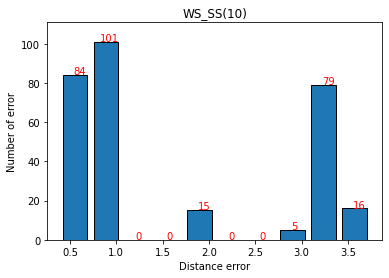

In [59]:
# Dinstance error histogram
import collections

err_counter = collections.Counter(err_lst)
err_cnt_item = sorted(err_counter.items(), key=lambda x:x[0])
x, y = [dist_err for dist_err, _ in err_cnt_item], [cnt for _, cnt in err_cnt_item]
x, y = np.array(x), np.array(y)


ys, xs, _ = plt.hist(x, bins = 10, weights = y, edgecolor='black', rwidth=0.8)
plt.xlabel('Distance error')
plt.ylabel('Number of error')
plt.ylim(0, max(ys) + 10)

for idx, yi in enumerate(ys):
    x_offset = {3: 0.1,
                2: 0.15,
                }.get(len(str(int(yi))), 0.15)
    plt.text(x=xs[idx] + x_offset, y=yi + 0.4,
            s=int(yi), color='red')
plt.title(CONSTRUCTION_OPT)
plt.savefig('error_histograms/{}.png'.format(CONSTRUCTION_OPT))

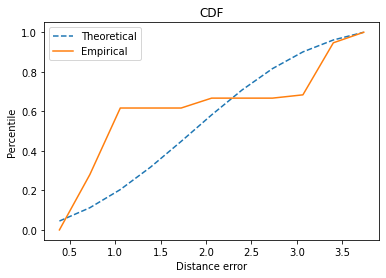

In [60]:
# CDF graph
th_y = ((1 / (np.sqrt(2 * np.pi) * x.std())) *
         np.exp(-0.5 * (1 / x.std() * (xs - x.mean())**2)))
th_cum_y = th_y.cumsum()
th_cum_y /= th_cum_y[-1]

em_cum_y = np.append(np.zeros((1)), ys).cumsum()
em_cum_y = em_cum_y / em_cum_y[-1]

plt.plot(xs, th_cum_y, label='Theoretical', linestyle = '--')
plt.plot(xs, em_cum_y, label='Empirical')
plt.xlabel('Distance error')
plt.ylabel('Percentile')
plt.title('CDF')
plt.legend()

# plt.savefig('CDF_graphs/{}.png'.format(CONSTRUCTION_OPT))

In [55]:
ss_4_x = xs
ss_4_y = em_cum_y

In [61]:
ss_10_x = xs
ss_10 = em_cum_y

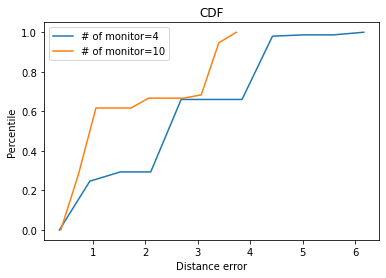

In [62]:
plt.plot(ss_4_x, ss_4, label='# of monitor=4')
plt.plot(ss_10_x, ss_10, label='# of monitor=10')
plt.xlabel('Distance error')
plt.ylabel('Percentile')
plt.title('CDF')
plt.legend()

In [53]:
# CDF graph - Percentile
def get_pcent():
    ############################################
    pcent_section = [0.50, 0.75, 0.90, 0.95, 1]
    ############################################
    for pcent in pcent_section:
        yield pcent

cum_y = y.cumsum()
cum_y = cum_y / cum_y[-1]

pcent_dic, gen = {int(pcent * 100): round(max(x), 2) for pcent in get_pcent()}, get_pcent()

pcent = next(gen)
for xi, yi in zip(x, cum_y):
    if yi >= pcent:
        pcent_dic[int(pcent * 100)] = round(xi, 2)
        try:
            pcent = next(gen)
        except:
            break


print(pcent_dic)
# To check error case
[(xi, yi) for xi, yi in zip(x, cum_y)]

{50: 2.23, 75: 3.92, 90: 4.77, 95: 4.77, 100: 6.17}


[(0.35999999999999943, 0.02),
 (0.3866666666666667, 0.24333333333333335),
 (0.5333333333333341, 0.24666666666666667),
 (1.2139924949429388, 0.29333333333333333),
 (2.1048937687631115, 0.3333333333333333),
 (2.2266666666666666, 0.6566666666666666),
 (2.598161743318619, 0.66),
 (3.9239804054330114, 0.98),
 (4.766666666666666, 0.9833333333333333),
 (4.7666666666666675, 0.9866666666666667),
 (6.16805479871896, 1.0)]